In [68]:

import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
import matplotlib.pyplot as plt


import monai
from monai.networks.nets import UNETR, UNet
from monai.utils import set_determinism,first
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import SliceInferer
from monai.visualize import matshow3d
from time import sleep

from samunetr.SAMUNETR import SAMUNETR

In [51]:
#Organize Picai Data

data_picai=pd.read_csv('/home/jaalzate/Tartaglia/Prostate_Tartaglia/codes/partition_1.csv')

data_picai["depth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[0])
data_picai["heigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[1])
data_picai["weigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[2])
data_picai=data_picai[(data_picai['heigth']!=0) & (data_picai['depth']!=0)]
data_picai=data_picai[(data_picai['heigth']>64) & (data_picai['depth']>64)]



data_picai=data_picai[data_picai['filepath_t2w_cropped'].notna()].reset_index()
data_picai_human=data_picai[data_picai['human_labeled']==1]
data_picai.drop(data_picai_human.index, inplace = True)

data_picai=data_picai[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_labelAI_cropped','filepath_seg_zones_cropped','partition']]
data_picai_human=data_picai_human[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_label_cropped','filepath_seg_zones_cropped','partition']]



train_picai=data_picai[data_picai['partition']=='tr']
test_picai=data_picai[data_picai['partition']=='dev']

train_picai_human=data_picai_human[data_picai_human['partition']=='tr']
test_picai_human=data_picai_human[data_picai_human['partition']=='dev']


In [52]:
#Organize Prostate158 Data
path='/nvmescratch/ceib/Prostate/input/prostate158/prostate158_train'
train_df_P158=pd.read_csv(os.path.join(path,'train.csv'))
test_df_P158=pd.read_csv(os.path.join(path,'valid.csv'))

columns = ['t2', 'adc', 'dwi','t2_anatomy_reader1', 'adc_tumor_reader1']

for df in [train_df_P158, test_df_P158]:
    for column in columns:
        df[column] = df[column].apply(lambda x: os.path.join(path,x))

In [53]:
#Combine Datasets

train_df = pd.DataFrame({
    't2w': list(train_picai['filepath_t2w_cropped'].values)+list(train_picai_human['filepath_t2w_cropped'].values)+list(train_df_P158['t2'].values),
    'adc': list(train_picai['filepath_adc_cropped'].values) + list(train_picai_human['filepath_adc_cropped'].values)+list(train_df_P158['adc'].values),
    'dwi': list(train_picai['filepath_hbv_cropped'].values) + list(train_picai_human['filepath_hbv_cropped'].values)+list(train_df_P158['dwi'].values),
    'zones': list(train_picai['filepath_seg_zones_cropped'].values) + list(train_picai_human['filepath_seg_zones_cropped'].values)+list(train_df_P158['t2_anatomy_reader1'].values),
    'label': list(train_picai['filepath_labelAI_cropped'].values) + list(train_picai_human['filepath_label_cropped'].values)+list(train_df_P158['adc_tumor_reader1'].values)
})

test_df = pd.DataFrame({
    't2w': list(test_picai['filepath_t2w_cropped'].values) + list(test_picai_human['filepath_t2w_cropped'].values)+list(test_df_P158['t2'].values),
    'adc': list(test_picai['filepath_adc_cropped'].values) +  list(test_picai_human['filepath_adc_cropped'].values)+list(test_df_P158['adc'].values) ,
    'dwi': list(test_picai['filepath_hbv_cropped'].values) + list(test_picai_human['filepath_hbv_cropped'].values)+list(test_df_P158['dwi'].values),
    'zones': list(test_picai['filepath_seg_zones_cropped'].values) + list(test_picai_human['filepath_seg_zones_cropped'].values)+list(test_df_P158['t2_anatomy_reader1'].values),
    'label': list(test_picai['filepath_labelAI_cropped'].values) + list(test_picai_human['filepath_label_cropped'].values)+list(test_df_P158['adc_tumor_reader1'].values)
})

In [54]:
print(train_df.shape)
print(test_df.shape)

(1014, 5)
(318, 5)


In [69]:
def Create_dataloaders(train_df,test_df,cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    #set_determinism(seed=0)

    img_columns=["t2","adc","dwi"]#,"adc","dwi"]
    label_column=["label"]
    
    mode=["bilinear","nearest"]#,"bilinear","bilinear","nearest"]#["bilinear","bilinear","bilinear", "nearest"]

    train_files = [{"t2": t2,'adc': adc,'dwi': dwi,"zones":zones, "label": label} for 
                   t2,adc,dwi,zones, label in zip(train_df['t2w'].values,
                                     train_df['adc'].values,
                                     train_df['dwi'].values,
                                     train_df['zones'].values,
                                     train_df['label'].values)]
    test_files = [{"t2": t2,'adc': adc,'dwi': dwi,"zones":zones, "label": label} for 
                   t2,adc,dwi,zones,label in zip(test_df['t2w'].values,
                                     test_df['adc'].values,
                                     test_df['dwi'].values,
                                     test_df['zones'].values,
                                     test_df['label'].values)]
    prob=0.175
    train_transforms = monai.transforms.Compose(
        [
            monai.transforms.LoadImaged(keys=img_columns+label_column+["zones"],reader="NibabelReader",image_only=True),
            monai.transforms.AsDiscreted(keys=label_column,threshold=1), #Convert values greater than 1 to 1
            monai.transforms.EnsureChannelFirstd(keys=img_columns+label_column+["zones"]),
            monai.transforms.AsDiscreted(keys="zones",argmax=True,to_onehot=3),
            monai.transforms.LabelToMaskd(keys="zones",select_labels=[1,2]),
            monai.transforms.ResampleToMatchd(keys=["adc","dwi","label"],key_dst="t2",mode=("bilinear","bilinear","nearest")),#Resample images to t2 dimension
            monai.transforms.ScaleIntensityd(keys=img_columns,minv=0.0, maxv=255.0),
            monai.transforms.NormalizeIntensityd(keys=img_columns,subtrahend=114.495, divisor=57.63),
            monai.transforms.ConcatItemsd(keys=img_columns+["zones"], name='image', dim=0),
            monai.transforms.ConcatItemsd(keys=label_column, name='label', dim=0),
            monai.transforms.Resized(keys=["image","label"],spatial_size=(128,128,-1),mode=("trilinear","nearest")),#SAMUNETR: Reshape to have the same dimension
            #monai.transforms.RandSpatialCropSamplesd(keys=['image','label'],roi_size=[96,96,-1],num_samples=2,random_size=False),#For the other models
            monai.transforms.RandRotate90d(keys=['image','label'],spatial_axes=[0,1],prob=prob),
            monai.transforms.RandZoomd(keys=['image','label'],min_zoom=0.9,max_zoom=1.1,mode=['area' if x == 'bilinear' else x for x in mode],prob=prob),
            monai.transforms.RandGaussianNoised(keys=["image"],mean=0.1,std=0.25,prob=prob),
            monai.transforms.RandShiftIntensityd(keys=["image"],offsets=0.2,prob=prob),
            monai.transforms.RandGaussianSharpend(keys=['image'],sigma1_x=[0.5, 1.0],sigma1_y=[0.5, 1.0],sigma1_z=[0.5, 1.0],sigma2_x=[0.5, 1.0],sigma2_y=[0.5, 1.0],sigma2_z=[0.5, 1.0],alpha=[10.0,30.0],prob=prob),
            monai.transforms.RandAdjustContrastd(keys=['image'],gamma=2.0,prob=prob),
            
        ]
    )
    test_transforms = monai.transforms.Compose(
        [
            monai.transforms.LoadImaged(keys=img_columns+label_column+["zones"],image_only=True),
            monai.transforms.AsDiscreted(keys=label_column,threshold=1), #Convert values greater than 1 to 1
            monai.transforms.EnsureChannelFirstd(keys=img_columns+label_column+["zones"]),
            monai.transforms.AsDiscreted(keys="zones",argmax=True,to_onehot=3),
            monai.transforms.LabelToMaskd(keys="zones",select_labels=[1,2]),
            monai.transforms.ResampleToMatchd(keys=["adc","dwi","label"],key_dst="t2",mode=("bilinear","bilinear","nearest")),#Resample images to t2 dimensions
            monai.transforms.ScaleIntensityd(keys=img_columns,minv=0.0, maxv=255.0),
            monai.transforms.NormalizeIntensityd(keys=img_columns,subtrahend=114.495, divisor=57.63),
            monai.transforms.ConcatItemsd(keys=img_columns+["zones"], name='image', dim=0),
            monai.transforms.ConcatItemsd(keys=label_column, name='label', dim=0),
            monai.transforms.Resized(keys=["image","label"],spatial_size=(128,128,-1),mode=("trilinear","nearest")),#SAMUNETR: Reshape to have the same dimension

            
        ]
    )
    
    
    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0,num_workers=8,copy_cache=False)#PerSlice(keys='image',transforms=train_transforms),cache_rate=1.0,num_workers=8,copy_cache=False)
        train_loader = DataLoader(train_ds, batch_size=1,shuffle=True)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0,num_workers=8,copy_cache=False)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

        return train_loader,train_ds, test_loader,test_ds

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1,shuffle=True)
        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1,shuffle=False)

        return train_loader,train_ds, test_loader,test_ds

In [74]:
def show_patient(data, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)


    if train:
        print('Train image shape: ', view_train_patient["image"].shape)
        #plt.figure("Visualization Train", (12, 6))
        #plt.subplot(1, 2, 1)
        image=monai.visualize.utils.blend_images(view_train_patient["image"][0,0:3],view_train_patient["label"][0], alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)
#         plt.title(f"image {SLICE_NUMBER}")
#         plt.imshow(view_train_patient["image"][0, 0, :, :, SLICE_NUMBER], cmap="gray")
        print('mean= ',view_train_patient["image"][0].mean())
        print('std= ',view_train_patient["image"][0].std())
        print('min= ',view_train_patient["image"][0].min())
        print('max= ',view_train_patient["image"][0].max())
        

#         plt.subplot(1, 2, 2)
#         plt.title(f"label {SLICE_NUMBER}")
#         plt.imshow(view_train_patient["label"][0, 0, :, :, SLICE_NUMBER])
        matshow3d(
            volume=image,
            fig=None, title="Train",
            figsize=(10, 10),
            every_n=1,
            frame_dim=-1,
            show=True,
            channel_dim=0
        )
        #plt.colorbar()
        plt.show()

    if test:
        print('Test image shape: ', view_test_patient["image"].shape)
        #plt.figure("Visualization Test", (12, 6))
        #plt.subplot(1, 2, 1)
        #plt.title(f"image {SLICE_NUMBER}")
        image=monai.visualize.utils.blend_images(view_test_patient["image"][0,2:5],view_test_patient["label"][0], alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)
        #plt.imshow(view_test_patient["image"][0, 0, :, :, SLICE_NUMBER], cmap="gray")
        print('mean= ',view_test_patient["image"][0].mean())
        print('std= ',view_test_patient["image"][0].std())
        print('min= ',view_test_patient["image"][0].min())
        print('max= ',view_test_patient["image"][0].max())
        

        #plt.subplot(1, 2, 2)
        #plt.title(f"label {SLICE_NUMBER}")
        #plt.imshow(view_test_patient["label"][0, 0, :, :, SLICE_NUMBER])
        matshow3d(
            volume=image,
            fig=None, title="Test",
            figsize=(10, 10),
            every_n=1,
            frame_dim=-1,
            show=True,
            channel_dim=0
        )
        #plt.colorbar()
        plt.show()

In [75]:
def train2D(model, data_in, loss, optim, max_epochs, model_dir,device,name, test_interval=1):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        ap_metric_train=0
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_data in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                train_step += 1
                #To convert images to 2D
                volume_list = list(batch_data["image"])
                label_list = list(batch_data["label"])
                volume=torch.cat(volume_list,axis=-1)
                label=torch.cat(label_list,axis=-1)

                volume = monai.transforms.Transpose((3,0,1,2))(volume)
                label=monai.transforms.Transpose((3,0,1,2))(label)

                #######################################
                #print('volume',volume.shape)
                #print('label',label.shape)
                volume, labels = (volume.to(device), label.to(device))
                optim.zero_grad()
                outputs = model(volume)#[0]
                
                train_loss = loss(outputs, labels)

                train_loss.backward()
                optim.step()

                train_epoch_loss += train_loss.item()
            
                labels_list = decollate_batch(labels)
                labels_convert = [post_label(label_tensor) for label_tensor in labels_list]
                
                output_list = decollate_batch(outputs)
                output_convert = [post_pred(output_tensor) for output_tensor in output_list]
                
                dice_metric(y_pred=output_convert, y=labels_convert)
                iou_metric(y_pred=output_convert, y=labels_convert)
            
                tepoch.set_postfix(loss=train_loss.item(), dice_score=dice_metric.aggregate(reduction="mean").item())
                sleep(0.1)

            print('-'*20)

            train_epoch_loss /= train_step
            print(f'Epoch_loss: {train_epoch_loss:.4f}')
            save_loss_train.append(train_epoch_loss)
            np.save(os.path.join(model_dir, name+'_loss_train.npy'), save_loss_train)

            epoch_metric_train = dice_metric.aggregate(reduction="mean").item()
            dice_metric.reset()

            print(f'Epoch_metric: {epoch_metric_train:.4f}')
            
            iou_metric_train = iou_metric.aggregate(reduction="mean").item()
            iou_metric.reset()

            print(f'IoU_metric: {iou_metric_train:.4f}')
            

            save_metric_train.append(epoch_metric_train)
            np.save(os.path.join(model_dir, name+'_metric_train.npy'), save_metric_train)

            if (epoch + 1) % test_interval == 0:

                model.eval()
                with torch.no_grad():
                    test_epoch_loss = 0
                    test_metric = 0
                    epoch_metric_test = 0
                    test_step = 0
                    ap_metric=0
                    for test_data in test_loader:
                        test_step += 1
                        test_volume, test_label = (test_data["image"].to(device),test_data["label"].to(device))
                        inferer=SliceInferer(roi_size=(96, 96),sw_batch_size=16,spatial_dim=2,cval=-1,progress=False)
                        test_outputs = inferer(test_volume, model)
                        
                        test_loss = loss(test_outputs, test_label)
                        test_epoch_loss += test_loss.item()
                        
                        labels_list = decollate_batch(test_label)
                        labels_convert = [post_label(label_tensor) for label_tensor in labels_list]

                        output_list = decollate_batch(test_outputs)
                        output_convert = [post_pred(output_tensor) for output_tensor in output_list]

                        dice_metric(y_pred=output_convert, y=labels_convert)
                        iou_metric(y_pred=output_convert, y=labels_convert)

                    test_epoch_loss /= test_step
                    print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                    save_loss_test.append(test_epoch_loss)
                    np.save(os.path.join(model_dir, name+'_loss_test.npy'), save_loss_test)

                    epoch_metric_test=dice_metric.aggregate(reduction="mean").item()
                    
                    print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                    print('test_dice_epoch_per_class:',dice_metric.aggregate())
                    
                    iou_metric_test=iou_metric.aggregate(reduction="mean").item()
                    
                    print(f'test_iou_epoch: {iou_metric_test:.4f}')
                    print('test_iou_epoch_per_class:',iou_metric.aggregate())
                    iou_metric.reset()
                    
                    save_metric_test.append(epoch_metric_test)
                    np.save(os.path.join(model_dir, name+'_metric_test.npy'), save_metric_test)
                    dice_metric.reset()
                    if epoch_metric_test > best_metric:
                        best_metric = epoch_metric_test
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), os.path.join(
                            model_dir, name+"_best_metric_model.pth"))

                    print(
                        f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}"
                        f"\nbest mean dice: {best_metric:.4f} "
                        f"at epoch: {best_metric_epoch}"
                    )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [76]:
#Creating dataloaders

train_loader,train_ds,val_loader,val_ds=Create_dataloaders(train_df,test_df,cache=False)

Modifying image pixdim from [0.3 0.3 3.6 1. ] to [  0.30000001   0.30000001   3.59999998 140.14361915]


Train image shape:  torch.Size([1, 5, 128, 128, 19])
mean=  tensor(-0.4812)
std=  tensor(0.8089)
min=  tensor(-1.9867)
max=  tensor(2.4165)


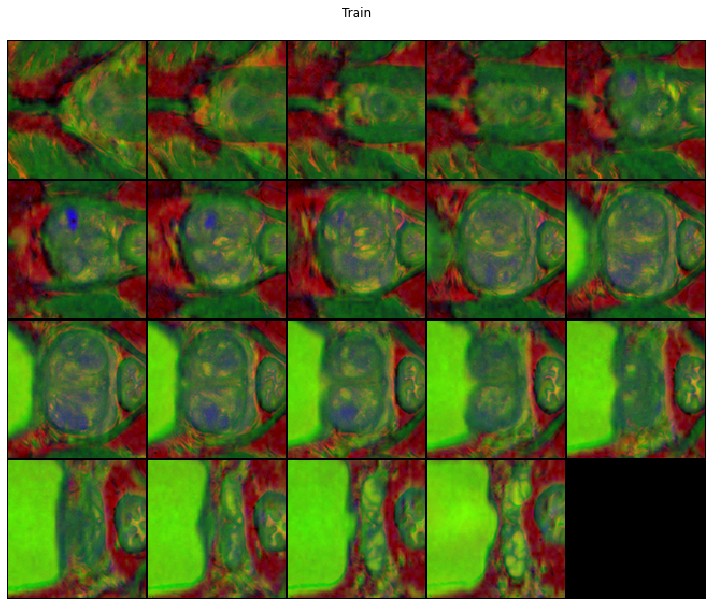

Test image shape:  torch.Size([1, 5, 128, 128, 23])
mean=  tensor(-0.6790)
std=  tensor(0.9217)
min=  tensor(-1.9867)
max=  tensor(2.4018)


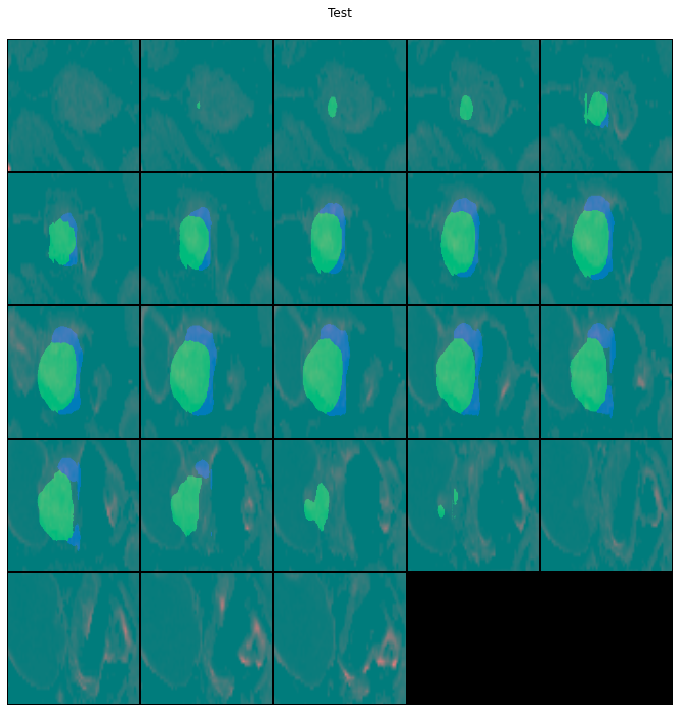

In [80]:
show_patient((train_loader,val_loader),train=True,test=True)

In [60]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Working on device: {device}')

Working on device: cuda


# Models

## Unet with Residual Units

In [61]:
UNet_meatdata = dict(
    spatial_dims=2,
    in_channels=5,
    out_channels=2,
    channels=[16, 32, 64, 128, 256, 512],
    strides=[2, 2, 2, 2, 2],
    num_res_units=4,
    norm='batch',
    act='PReLU',
    dropout=0.15
)

model = UNet(**UNet_meatdata).to(device)

## SwinUnet using pretrained weigths

In [ ]:
model=monai.networks.nets.SwinUNETR(
    img_size=(96, 96),
    in_channels=5,
    out_channels=2,
    feature_size=48,
    use_checkpoint=False,
    norm_name="batch",
    depths=(2, 2, 2,2),
    spatial_dims=2,
    drop_rate=0.15
).to(device)

#Pretrained Encoder   
weight = torch.load("/home/jaalzate/Tartaglia/Prostate_Tartaglia/codes/model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

## Unetr

In [ ]:
model = UNETR(
    in_channels=5,
    out_channels=2,
    img_size=(96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=24,
    pos_embed="conv",
    norm_name="batch",
    res_block=True,
    dropout_rate=0.15,
    spatial_dims=2,
).to(device)

## SAMUnetr

In [ ]:
model=SAMUNETR(img_size=128,in_channels= 5,out_channels=2,trainable_encoder=True,pretrained=True).to(device)

# Training Model

In [62]:
print(model)

#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True,include_background=False)
#loss_function = monai.losses.DiceFocalLoss(to_onehot_y=True, softmax=True,include_background=False)

torch.backends.cudnn.benchmark = True
optimizer = monai.optimizers.Novograd(model.parameters(), lr=0.001, weight_decay=0.01)



UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(5, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [63]:
data_in=(train_loader,val_loader)
model_dir='/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results'

In [67]:
post_pred = monai.transforms.Compose(
        monai.transforms.AsDiscrete(argmax=True, to_onehot=2, num_classes=2),
        monai.transforms.KeepLargestConnectedComponent(applied_labels=list(range(1, 2))),
    )

post_label = monai.transforms.AsDiscrete(to_onehot=2)
dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
iou_metric=monai.metrics.MeanIoU(include_background=False,reduction="mean",get_not_nans=False)

train2D(model, data_in, loss_function, optimizer, 200, model_dir,device=device,name='Unet_96_96')

----------
epoch 1/200


Epoch 1:   3%|▎         | 32/1014 [00:34<17:35,  1.07s/batch, dice_score=0.0643, loss=1.38]


KeyboardInterrupt: 